In [1]:
import pandas as pd
import numpy as np

In [2]:
colnames = ["chromosome","position","leaf.1","leaf.2","leaf.3","leaf.4","leaf.5","leaf.6","leaf.7",
                      "leaf.8","leaf.9","leaf.10","leaf.11","inner.12","inner.13","inner.14","inner.15",
                      "inner.16","inner.17","inner.18","inner.19","inner.20","hg18","rheMac2"]
anc = pd.read_csv("/projects/kernlab/shared/greatapes/ancestral_alleles/chr12.calls.txt.gz", 
                  compression="gzip", header=None, skiprows=1, sep="\t", names=colnames)

In [3]:
anc.head()

,chromosome,position,leaf.1,leaf.2,leaf.3,leaf.4,leaf.5,leaf.6,leaf.7,leaf.8,...,inner.13,inner.14,inner.15,inner.16,inner.17,inner.18,inner.19,inner.20,hg18,rheMac2
0,chr12,16003,a/g,?,?,?,?,?,?,?,...,a/g,a/g,a/g,a/g,a/g,a/g,a/g,a/g,-,-
1,chr12,16016,t/g,?,?,?,?,?,?,?,...,t/g,t/g,t/g,t/g,t/g,t/g,t/g,t/g,-,-
2,chr12,16063,C/T,C,C,C,C,C,C,C,...,C,C,C/T,C,C,C,C,C,-,-
3,chr12,16084,G,G,G/C,G,G,G,?,?,...,G,G/C,g/c,G/C,G,G,G,g/c,-,-
4,chr12,16095,A,A/G,A,A,A,A,A,A,...,A/G,A,A/G,A/G,A,A,A,A,-,-


In [4]:
pop1 = "leaf.1" # humans
pop2 = "leaf.10" # orang
win_size = 1000000
mrca = "inner.20" # great apes node

In [5]:
possible_states = set(["A", "T", "C", "G"])
possible_poly_states = {
    state: [f'{state}/{other}' for other in possible_states - set(state)] + [f'{other}/{state}' for other in possible_states - set(state)] for state in possible_states
}

bgc_classes = {"W":["A", "T"],
              "S":["G","C"]}

w_to_s = [f"{prefix}{poly}{suffix}" for state in bgc_classes["W"] 
          for prefix, suffix in zip(["", f"{state}-"],[f"-{state}-{state}", f"-{state}"]) 
          for poly in possible_poly_states[state]  if any([class_state in poly.replace(state,"") 
                                                           for class_state in bgc_classes["S"]])]
w_to_w = [f"{prefix}{poly}{suffix}" for state in bgc_classes["W"] 
          for prefix, suffix in zip(["", f"{state}-"],[f"-{state}-{state}", f"-{state}"]) 
          for poly in possible_poly_states[state]  if any([class_state in poly.replace(state,"") 
                                                           for class_state in bgc_classes["W"]])]
all_called_states = list(possible_states | set(possible_poly_states["A"] + possible_poly_states["G"] + possible_poly_states["T"] + possible_poly_states["C"]))

In [6]:
possible_poly_states

{'T': ['T/A', 'T/G', 'T/C', 'A/T', 'G/T', 'C/T'],
 'A': ['A/T', 'A/G', 'A/C', 'T/A', 'G/A', 'C/A'],
 'G': ['G/T', 'G/A', 'G/C', 'T/G', 'A/G', 'C/G'],
 'C': ['C/T', 'C/A', 'C/G', 'T/C', 'A/C', 'G/C']}

In [7]:
all_called_states

['C/T',
 'G/C',
 'C/G',
 'T',
 'C',
 'G/T',
 'C/A',
 'G',
 'A/G',
 'A',
 'T/C',
 'A/T',
 'T/G',
 'A/C',
 'T/A',
 'G/A']

In [8]:
# these are all the possible configurations for W->S mutation
# {state in pop 1}-{state in pop 2}-{state in ancestor}
w_to_s

['A/G-A-A',
 'A/C-A-A',
 'G/A-A-A',
 'C/A-A-A',
 'A-A/G-A',
 'A-A/C-A',
 'A-G/A-A',
 'A-C/A-A',
 'T/G-T-T',
 'T/C-T-T',
 'G/T-T-T',
 'C/T-T-T',
 'T-T/G-T',
 'T-T/C-T',
 'T-G/T-T',
 'T-C/T-T']

In [9]:
w_to_w

['A/T-A-A',
 'T/A-A-A',
 'A-A/T-A',
 'A-T/A-A',
 'T/A-T-T',
 'A/T-T-T',
 'T-T/A-T',
 'T-A/T-T']

In [10]:
nums_wtos = []
nums_wtow = []

nums_anc_w = []
nums_called = []
for win_start in range(1,132289527-win_size,win_size):
    win_end = win_start + win_size
    subset = anc.loc[(anc.position >= win_start) & (anc.position < win_end)]

    num_w_to_s = np.sum(np.in1d(subset[[pop1, pop2, mrca]].agg('-'.join, axis=1).to_numpy(), w_to_s))
    num_w_to_w = np.sum(np.in1d(subset[[pop1, pop2, mrca]].agg('-'.join, axis=1).to_numpy(), w_to_w))


    num_anc_w = np.sum(np.in1d(subset[mrca].to_numpy(), bgc_classes["W"]))
    nums_wtos.append(num_w_to_s)
    nums_wtow.append(num_w_to_w)
    num_called = np.sum(np.sum((np.in1d(subset[pop1].to_numpy(), all_called_states), np.in1d(subset[pop2].to_numpy(), all_called_states), np.in1d(subset[mrca].to_numpy(), np.array(list(possible_states)))), axis=0) == 3)
    nums_anc_w.append(num_anc_w)
    nums_called.append(num_called)

In [11]:
nums_anc_w = np.array(nums_anc_w)
nums_called = np.array(nums_called)
nums_wtos = np.array(nums_wtos)
nums_wtow = np.array(nums_wtow)

In [12]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Number of W->S mutations')

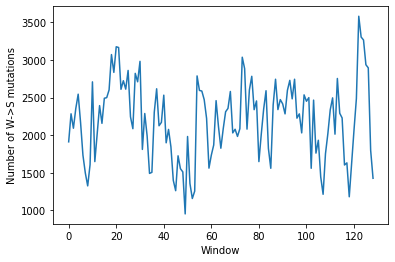

In [13]:
plt.plot(nums_wtos[nums_called>10000])
plt.xlabel("Window")
plt.ylabel("Number of W->S mutations")

Text(0, 0.5, 'Number of W->S mutations / Number of sites with confident state calls')

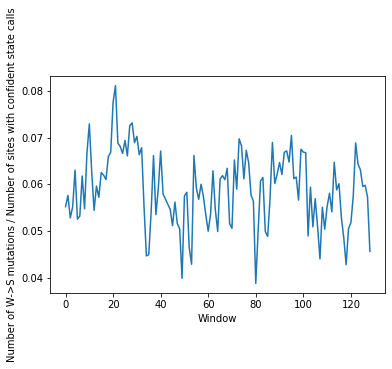

In [14]:
plt.plot(nums_wtos[nums_called>10000]/nums_called[nums_called>10000])
plt.xlabel("Window")
plt.ylabel("Number of W->S mutations / Number of sites with confident state calls")

Text(0.5, 0, 'Number of W->S mutations / Number of sites where ancestral was W')

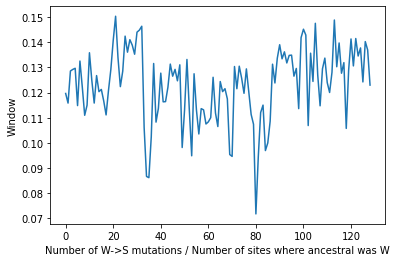

In [15]:
plt.plot(np.array(nums_wtos[nums_called>10000])/np.array(nums_anc_w[nums_called>10000]))
plt.ylabel("Window")
plt.xlabel("Number of W->S mutations / Number of sites where ancestral was W")

Text(0, 0.5, 'Number of W->W mutations')

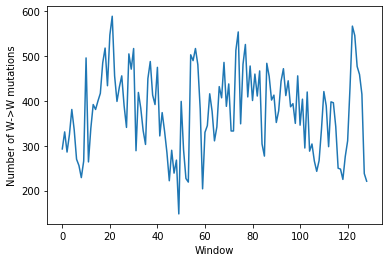

In [16]:
plt.plot(nums_wtow[nums_called>10000])
plt.xlabel("Window")
plt.ylabel("Number of W->W mutations")

Text(0.5, 0, 'Number of W->W mutations / Number of sites where ancestral was W')

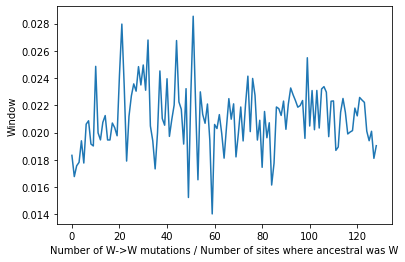

In [17]:
plt.plot(np.array(nums_wtow[nums_called>10000])/np.array(nums_anc_w[nums_called>10000]))
plt.ylabel("Window")
plt.xlabel("Number of W->W mutations / Number of sites where ancestral was W")

Text(0, 0.5, 'Number of W->W mutations / Number of sites with confident state calls')

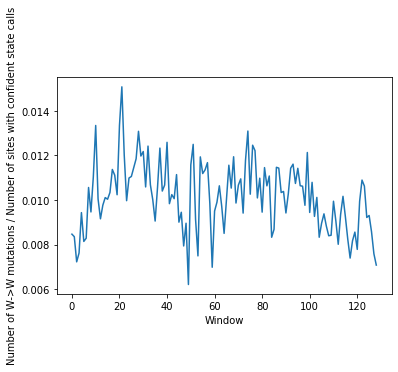

In [18]:
plt.plot(nums_wtow[nums_called>10000]/nums_called[nums_called>10000])
plt.xlabel("Window")
plt.ylabel("Number of W->W mutations / Number of sites with confident state calls")

Text(0.5, 0, 'Number of W->S mutations / Number of W->W')

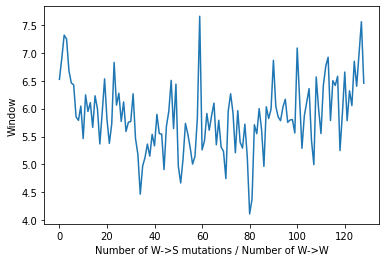

In [19]:
plt.plot(np.array(nums_wtos[nums_called>10000])/np.array(nums_wtow[nums_called>10000]))
plt.ylabel("Window")
plt.xlabel("Number of W->S mutations / Number of W->W")